# Exploratory Data Analysis of collected rental data 
### Data was collected from one website with a separation of Toronto and Ottawa
#### 'See Rentals_Ottawa_data_collection.ipynb' and 'Rentals_Ottawa_data_collection.ipynb' to find how data was collected

In [17]:
# For data wrangling
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# For creating plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [18]:
# Data Pull
df_ot = pd.read_excel(r'D:\Projects\Rentals\rental_data_ottawa_1.xlsx')
df_to = pd.read_excel(r'D:\Projects\Rentals\rental_data_toronto_1.xlsx')

# Combine dataframes into one
df = pd.concat([df_ot, df_to], axis=0, ignore_index=True)

# Display the count of the DataFrames
print("Number of Rows in Ottawa Data:", df_ot.shape[0])
print("Number of Rows in Toronto Data:", df_to.shape[0])
print("Number of Rows in Combined Data:", df.shape[0])

Number of Rows in Ottawa Data: 762
Number of Rows in Toronto Data: 850
Number of Rows in Combined Data: 1612


## Data Clean-Up

#### Fix incorrect or missing Cities

In [19]:
# Fix the missing cities

def update_city(row):
    address = row['Address'].lower()  # Convert address to lowercase for case-insensitive matching
    if 'ottawa' in address or 'nepean' in address or 'gloucester' in address:
        return 'Ottawa'
    elif 'toronto' in address or 'east york' in address or 'richmond' in address or 'north york' in address or 'york' in address or 'scarborough' in address or 'etobicoke' in address:
        return 'Toronto'
    return row['City']

# Apply the custom function to update the "City" column
df['City'] = df.apply(update_city, axis=1)

# Display the updated DataFrame
print(df.head())


     City Property Type Bedrooms  Bathrooms  Square Footage                                Address Zip code          Price
0  Ottawa     apartment      1-2        2.0           856.0            90 Champagne  - Ottawa , ON  K1S 4P1  $2100 - $2900
1  Ottawa     apartment      0-1        1.0           756.0   253 - 257 York Street  - Ottawa , ON  K1N 5T9  $1675 - $1850
2  Ottawa     apartment      0-1        1.0           470.0            86-92 Hinton  - Ottawa , ON  K1Y 2Z7  $1700 - $2200
3  Ottawa     apartment      0-2        1.0           167.0              256 Rideau  - Ottawa , ON  K1N 0A9  $1285 - $2970
4  Ottawa     apartment        1        1.0          1010.0  150-152 Osgoode Street  - Ottawa , ON  K1N 8A4          $1400


#### Split Price to have a Minimum, Maximum, and Average Price

In [20]:
# Split the Price column into two columns
df[['MinPrice', 'MaxPrice']] = df['Price'].str.split('-', expand=True)

# Strip whitespace and remove the dollar sign from the columns
df['MinPrice'] = df['MinPrice'].str.strip().str.replace('$', '').astype(float)
df['MaxPrice'] = df['MaxPrice'].str.strip().str.replace('$', '').astype(float)

# Calculate the average of Price1 and Price2, handling missing values
df['Average_Price'] = df[['MinPrice', 'MaxPrice']].mean(axis=1, skipna=True)


# Display the updated DataFrame
print(df.head())

     City Property Type Bedrooms  Bathrooms  Square Footage                                Address Zip code          Price  MinPrice  MaxPrice  Average_Price
0  Ottawa     apartment      1-2        2.0           856.0            90 Champagne  - Ottawa , ON  K1S 4P1  $2100 - $2900    2100.0    2900.0         2500.0
1  Ottawa     apartment      0-1        1.0           756.0   253 - 257 York Street  - Ottawa , ON  K1N 5T9  $1675 - $1850    1675.0    1850.0         1762.5
2  Ottawa     apartment      0-1        1.0           470.0            86-92 Hinton  - Ottawa , ON  K1Y 2Z7  $1700 - $2200    1700.0    2200.0         1950.0
3  Ottawa     apartment      0-2        1.0           167.0              256 Rideau  - Ottawa , ON  K1N 0A9  $1285 - $2970    1285.0    2970.0         2127.5
4  Ottawa     apartment        1        1.0          1010.0  150-152 Osgoode Street  - Ottawa , ON  K1N 8A4          $1400    1400.0       NaN         1400.0


#### Split Bedroom column to have a Minimum, Maximum, and Average Bedroom number

In [21]:
# Split the Price column into two columns
df[['Min_Bed', 'Max_Bed']] = df['Bedrooms'].str.split('-', expand=True)

# Strip whitespace and remove the dollar sign from the columns
df['Min_Bed'] = df['Min_Bed'].str.strip().str.replace('$', '').astype(float)
df['Max_Bed'] = df['Max_Bed'].str.strip().str.replace('$', '').astype(float)

# Calculate the average of Price1 and Price2, handling missing values
df['Average_Bed'] = df[['Min_Bed', 'Max_Bed']].mean(axis=1, skipna=True)


# Display the updated DataFrame
print(df.head())

     City Property Type Bedrooms  Bathrooms  Square Footage                                Address Zip code          Price  MinPrice  MaxPrice  Average_Price  Min_Bed  Max_Bed  Average_Bed
0  Ottawa     apartment      1-2        2.0           856.0            90 Champagne  - Ottawa , ON  K1S 4P1  $2100 - $2900    2100.0    2900.0         2500.0      1.0      2.0          1.5
1  Ottawa     apartment      0-1        1.0           756.0   253 - 257 York Street  - Ottawa , ON  K1N 5T9  $1675 - $1850    1675.0    1850.0         1762.5      0.0      1.0          0.5
2  Ottawa     apartment      0-1        1.0           470.0            86-92 Hinton  - Ottawa , ON  K1Y 2Z7  $1700 - $2200    1700.0    2200.0         1950.0      0.0      1.0          0.5
3  Ottawa     apartment      0-2        1.0           167.0              256 Rideau  - Ottawa , ON  K1N 0A9  $1285 - $2970    1285.0    2970.0         2127.5      0.0      2.0          1.0
4  Ottawa     apartment        1        1.0          10

In [22]:
# Reorganize Columns
desired_column_order =['City', 'Property Type', 'Bedrooms','Average_Bed', 'Bathrooms', 
                        'Square Footage', 'Address', 'Zip code', 'Price',
                       'Average_Price', 'MinPrice', 'MaxPrice', 'Min_Bed','Max_Bed',  
                       ]
df = df[desired_column_order]

# Convert columns to numeric data types, replacing non-numeric values with NaN
numeric_columns = ['Square Footage', 'Bedrooms', 'Bathrooms', 'Price']
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Check for missing values (NaN)
print(df.isnull().sum())

City                 0
Property Type        0
Bedrooms           279
Average_Bed          0
Bathrooms           20
Square Footage     471
Address              0
Zip code             0
Price             1612
Average_Price        0
MinPrice             0
MaxPrice          1287
Min_Bed              0
Max_Bed           1333
dtype: int64


In [26]:
# Save as an excel file to be mapped on Tableau
column_drop = ['MinPrice','MaxPrice','Min_Bed','Max_Bed','Bedrooms','Bathrooms']
x_df = df.copy()
x_df['Country'] = 'Canada'
x_df.drop(columns = column_drop, inplace=True )
x_df.reset_index(drop=False)

# Save to excel file
x_df.to_excel("rental_data_clean.xlsx",index=False)
x_df.columns

Index(['City', 'Property Type', 'Average_Bed', 'Square Footage', 'Address', 'Zip code', 'Price', 'Average_Price', 'Country'], dtype='object')

## Plots of Cleaned Data

In [27]:
# Unique Column Names
df.columns

Index(['City', 'Property Type', 'Bedrooms', 'Average_Bed', 'Bathrooms', 'Square Footage', 'Address', 'Zip code', 'Price', 'Average_Price', 'MinPrice', 'MaxPrice', 'Min_Bed', 'Max_Bed'], dtype='object')

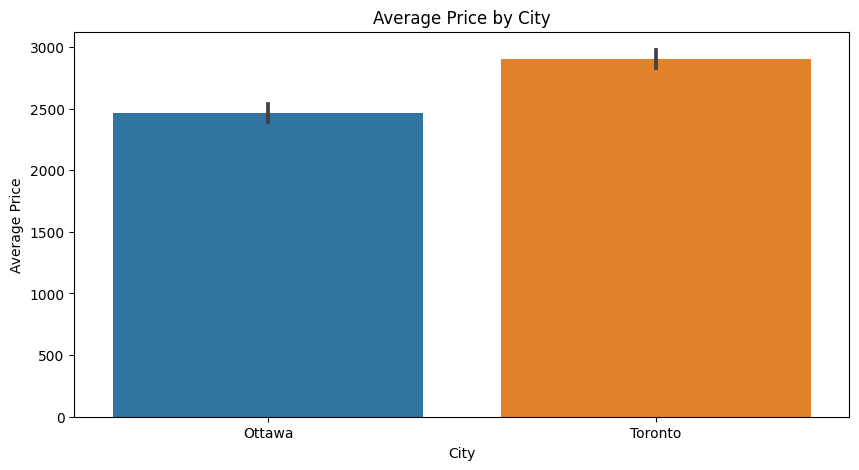

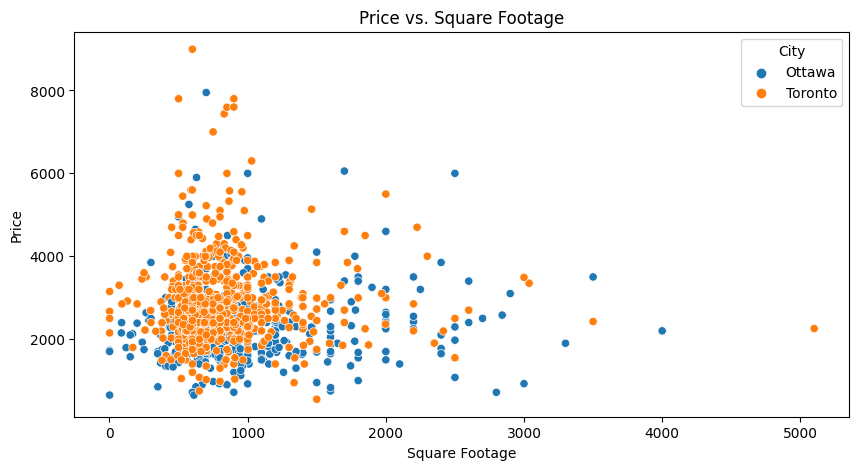

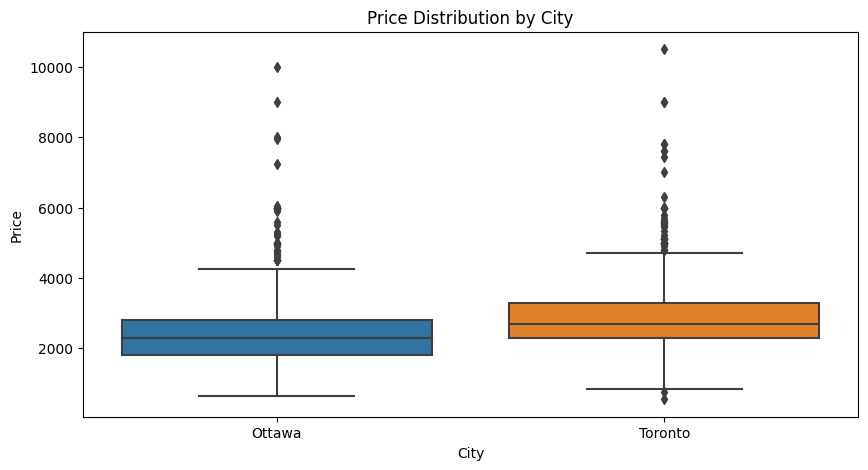

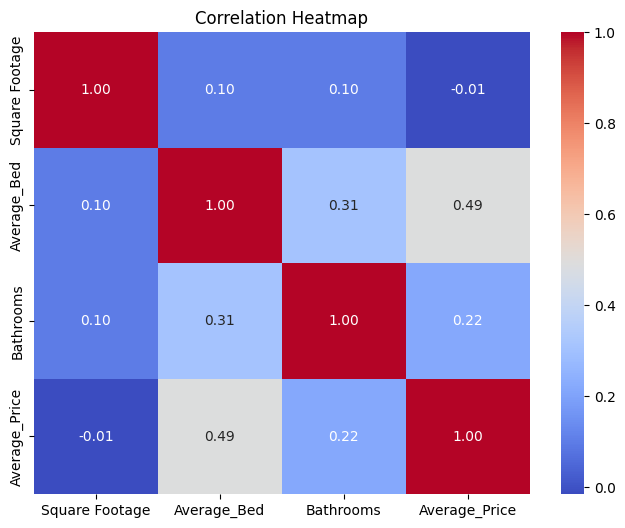

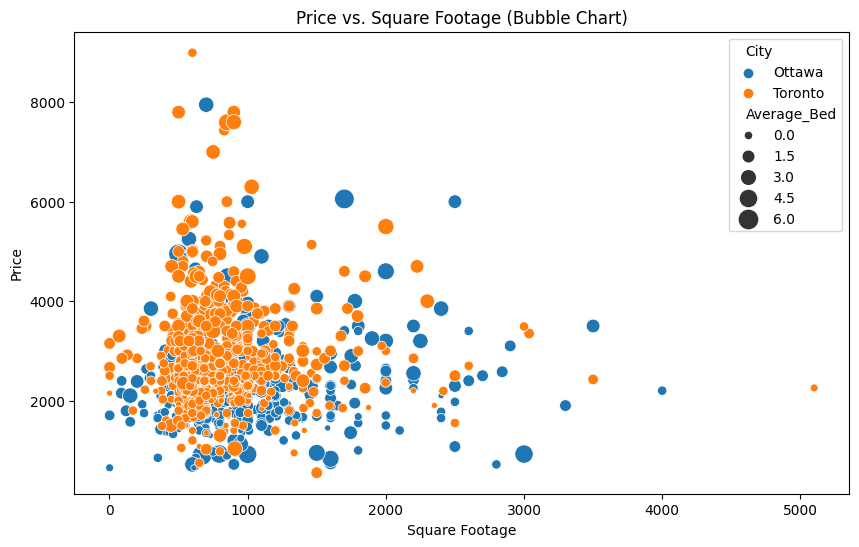

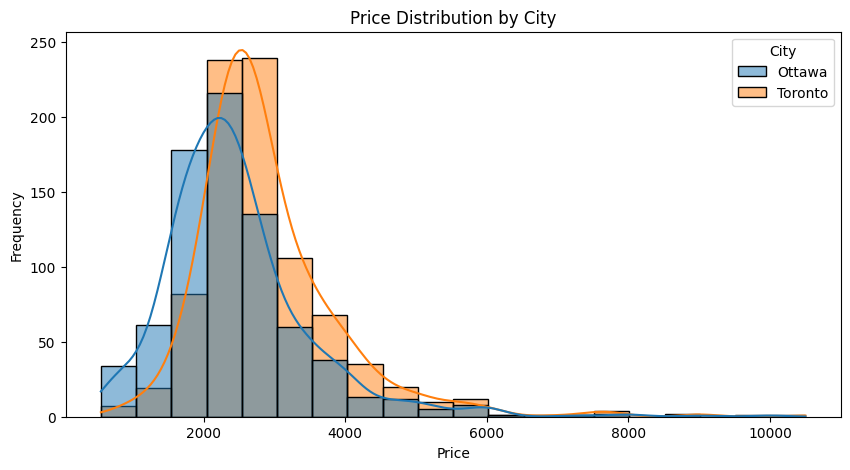

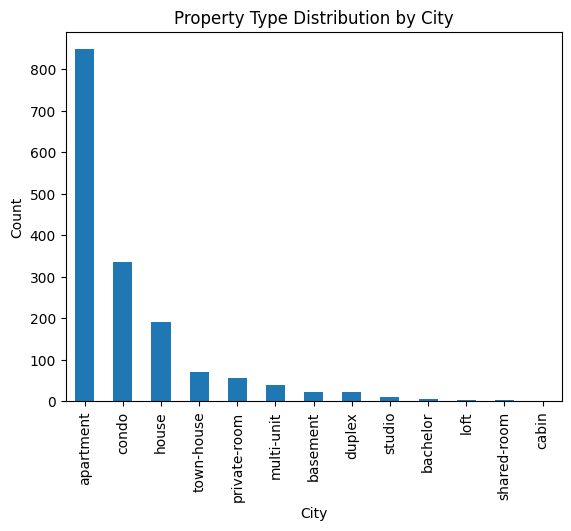

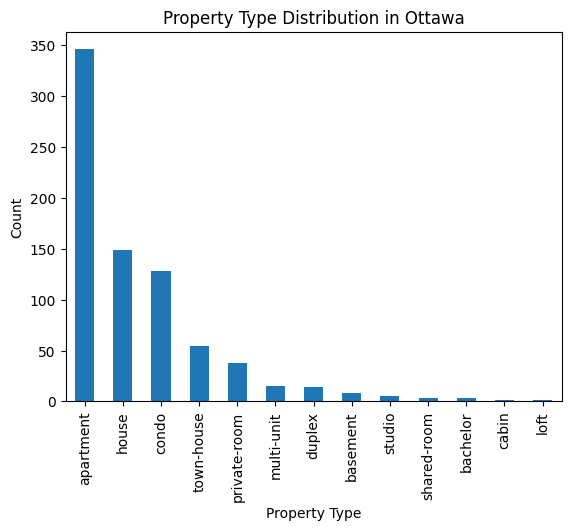

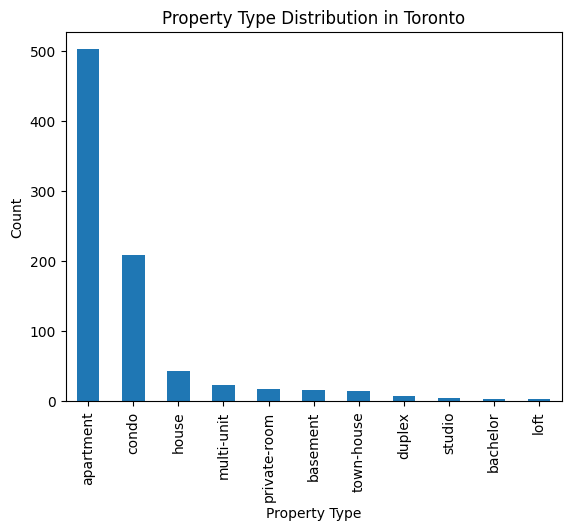

In [25]:
# 1. Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x='City', y='Average_Price', data=df)
plt.title('Average Price by City')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.show()

# 2. Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Square Footage', y='Average_Price', data=df, hue='City')
plt.title('Price vs. Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.show()

# 3. Box Plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='City', y='Average_Price', data=df)
plt.title('Price Distribution by City')
plt.xlabel('City')
plt.ylabel('Price')
plt.show()

# 4. Heatmap (Correlation)
correlation_matrix = df[['Square Footage', 'Average_Bed', 'Bathrooms', 'Average_Price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 5. Line Plot (Assuming you have time-related data)
# Here, you would need time-related data for this plot, which is not available in the provided columns.

# 6. Bubble Chart
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Square Footage', y='Average_Price', data=df, hue='City', size='Average_Bed', sizes=(20, 200))
plt.title('Price vs. Square Footage (Bubble Chart)')
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.show()

# 7. Histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Average_Price', bins=20, kde=True, hue='City')
plt.title('Price Distribution by City')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 8. Stacked Bar Chart - Average
df['Property Type'].value_counts().plot(kind='bar', stacked=True)
plt.title('Property Type Distribution by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

# 9. Stacked Bar Chart - Per City
# Get unique city names
unique_cities = df['City'].unique()

# Create a stacked bar chart for each city
for city in unique_cities:
    city_data = df[df['City'] == city]
    property_type_counts = city_data['Property Type'].value_counts()
    
    # Create a stacked bar chart for the current city
    property_type_counts.plot(kind='bar', stacked=True)
    plt.title(f'Property Type Distribution in {city}')
    plt.xlabel('Property Type')
    plt.ylabel('Count')
    plt.show()